In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display
from scipy.linalg import inv
import functions.filter as KF
import yfinance as yf

In [21]:
instruments = ['NVDA','C','CVX','AAPL','MS','^GSPC','^IXIC','^VIX','^TNX']
df = yf.download(instruments,period='5y',interval='1d')
data = df['Adj Close']
data.tail()

[*********************100%***********************]  9 of 9 completed


,AAPL,C,CVX,MS,NVDA,^GSPC,^IXIC,^TNX,^VIX
Date,,,,,,,,,
2022-05-23,143.110001,52.770000,171.720001,82.309998,168.979996,3973.750000,11535.269531,2.859,28.480000
2022-05-24,140.360001,52.680000,172.639999,81.959999,161.539993,3941.479980,11264.450195,2.760,29.450001
2022-05-25,140.520004,52.700001,175.410004,82.230003,169.750000,3978.729980,11434.740234,2.749,28.370001
2022-05-26,143.779999,54.090000,176.589996,85.000000,178.509995,4057.840088,11740.650391,2.756,27.500000
2022-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.180000


In [26]:
df = data[ ["AAPL","^GSPC"] ]

In [29]:
history_len = 1000                              # lenght of the time series 
df.sort_index(inplace=True, ascending =True)    # not necessary in general, but useful
df = df.dropna(axis=1, how='all')               # drops columns with all NaNs
df = df.dropna(axis=0, how='all')               # drops rows with at least one NaN
df = df[-history_len:]
df = df.ffill()                                 # Forward fill
print("Are there still some NaNs? "); df.isnull().any()

Are there still some NaNs? 


AAPL     False
^GSPC    False
dtype: bool

In [30]:
returns = "log-returns"

if returns=="log-returns":
    ret = np.log( df/df.shift() )[1:]
elif returns=="linear-returns":  
    ret = df.pct_change()[1:]
elif returns=="total-returns":
    ret = df/df.shift()[1:]



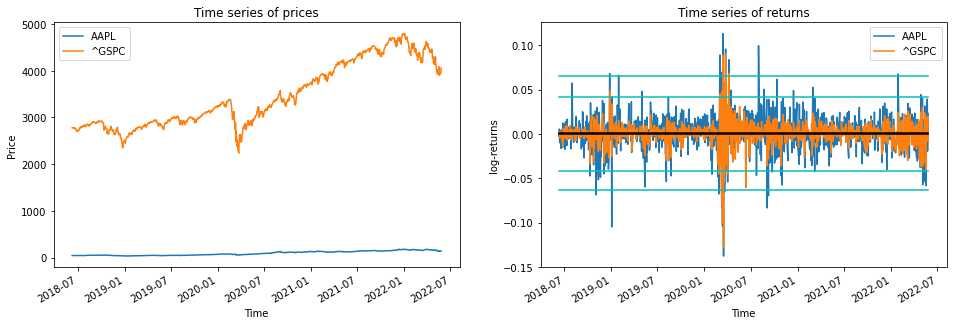

In [31]:
NOSD = 3               # Number Of Standard Deviations
mu = ret.mean()
sig = ret.std()
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

df.plot(ax=ax1)
ax1.set_title("Time series of prices"); ax1.set_xlabel("Time"); ax1.set_ylabel("Price")
ret.plot(ax=ax2)
ax2.set_title("Time series of returns"); ax2.set_xlabel("Time"); ax2.set_ylabel(returns)
ax2.plot(ret.index, len(ret)*[mu], color="k" )
ax2.plot(ret.index, len(ret)*[mu+NOSD*sig], color='c' )
ax2.plot(ret.index, len(ret)*[mu-NOSD*sig], color='c' )
plt.show()

In [32]:
median = ret.median()
MAD = ret.mad()
sig_robust = MAD*1.4826
print("STD DEV: \n", sig); print(""); print("Robust STD DEV: \n", sig_robust); 

STD DEV: 
 AAPL     0.021362
^GSPC    0.013900
dtype: float64

Robust STD DEV: 
 AAPL     0.022085
^GSPC    0.012824
dtype: float64


In [34]:
outliers = ret[ret[ np.abs(ret-median)>NOSD*sig_robust ].any(axis=1)]     # outliers
dret = ret.drop(outliers.index)   

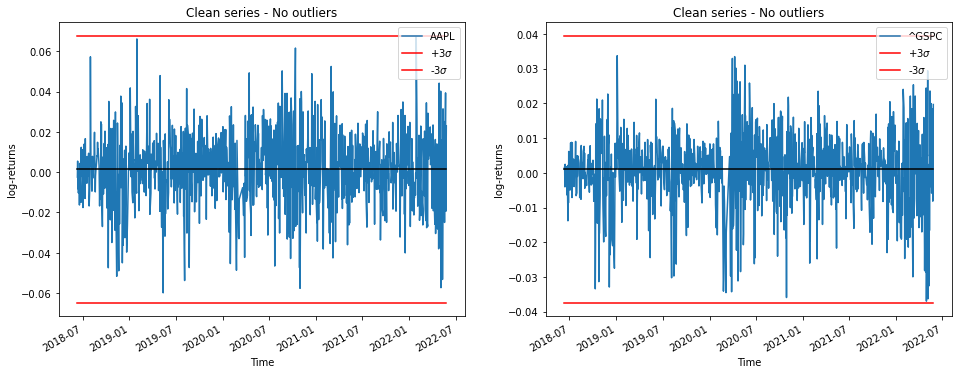

In [35]:


fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122) 

for ax, col in zip([ax1,ax2], dret.columns):
    dret[col].plot(ax=ax)
    ax.set_title("Clean series - No outliers"); ax.set_xlabel("Time"); ax.set_ylabel(returns)
    ax.plot(dret.index, len(dret)*[median[col]], color="k" )
    ax.plot(dret.index, len(dret)*[median[col]+NOSD*sig_robust[col]], color='r', label="+3$\sigma$" )
    ax.plot(dret.index, len(dret)*[median[col]-NOSD*sig_robust[col]], color='r', label="-3$\sigma$" )
    ax.legend(loc="upper right")
plt.show()



In [36]:


print("We have reduced the initial DIRTY series of returns of size {} to the \
new CLEAN series of size {}.".format(len(ret),len(dret)))



We have reduced the initial DIRTY series of returns of size 999 to the new CLEAN series of size 975.


In [37]:


X = dret[dret.columns[1]]
Y = dret[dret.columns[0]]
print("In our regression Y is {} and X is {}".format(dret.columns[0],dret.columns[1]) )
b_ss, a_ss, r_ss, _, std_err_ss = ss.linregress(X,Y)
print("We can use one of the many python functions:\nbeta: {0:6f}, alpha: {1:6f}, R2: {2:6f}, \
standard error: {3:6f}.".format(b_ss, a_ss, r_ss**2, std_err_ss))

beta_tot_OLS = np.cov(X,Y,ddof=1)[0,1] / np.var(X,ddof=1)
alpha_tot_OLS = np.mean(Y) - beta_tot_OLS * np.mean(X)
res = Y - beta_tot_OLS * X - alpha_tot_OLS
std_eps_OLS = np.std(res, ddof=2) 
print("\nOr I can estimate by myself:\nbeta: {}, alpha: {}, sigma: {}".format(beta_tot_OLS, 
                                                                             alpha_tot_OLS, std_eps_OLS))


n = len(X)
x_mean = np.mean(X); y_mean = np.mean(Y)
Sxx = (X-x_mean) @ (X-x_mean)
Syy = (Y-y_mean) @ (Y-y_mean)
Sxy = (X-x_mean) @ (Y-y_mean)
beta_hat = Sxy/Sxx; alpha_hat = y_mean - beta_hat * x_mean    # beta and alpha
print("beta: {} and alpha: {}".format(beta_hat,alpha_hat))
epsilon = Y - beta_hat * X - alpha_hat             # residuals
S2 = epsilon @ epsilon / (n-2); S = np.sqrt(S2)    # unbiased estimator
print("sigma: {}".format(S))
var_beta = S2/Sxx                 # variance of beta 
var_alpha = (X@X) * S2/(Sxx * n)  # variance of alpha 
s_b = np.sqrt(var_beta)           # standard error for beta
s_a = np.sqrt(var_alpha)          # standard error for alpha
R2 = Sxy**2 / (Sxx*Syy)           
print("Standard Error for beta: ", s_b); print("R squared: {}".format(R2))
CI_b = ss.t.interval(0.95, n-2, loc=beta_hat, scale=s_b );  b_up = CI_b[0]; b_down = CI_b[1]
CI_a = ss.t.interval(0.95, n-2, loc=alpha_hat, scale=s_a )
print("Confidence intervals for beta: ", CI_b); print("Confidence intervals for alpha: ", CI_a)



In our regression Y is AAPL and X is ^GSPC
We can use one of the many python functions:
beta: 1.270055, alpha: 0.000685, R2: 0.546675, standard error: 0.037077.

Or I can estimate by myself:
beta: 1.2700545624833408, alpha: 0.000685271780506637, sigma: 0.01198748918871163
beta: 1.2700545624833401 and alpha: 0.0006852717805066373
sigma: 0.011987489188711627
Standard Error for beta:  0.037077099222611175
R squared: 0.5466754998205337
Confidence intervals for beta:  (1.1972942750413456, 1.3428148499253347)
Confidence intervals for alpha:  (-6.928628191565022e-05, 0.0014398298429289247)


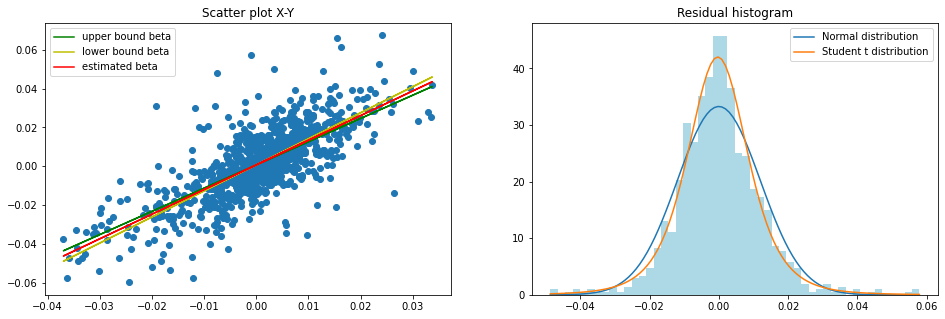

Degrees of freedom of fitted t distribution:  4.387644088920029


In [38]:


x = np.linspace(res.min(),res.max(),100)     # res are the residuals

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.scatter(X, Y); ax1.set_title("Scatter plot X-Y") 
ax1.plot(X, alpha_hat + b_up*X, color="g", label="upper bound beta")
ax1.plot(X, alpha_hat + b_down*X, color="y", label="lower bound beta")
ax1.plot(X, alpha_hat + beta_hat*X, color="red", label="estimated beta"); ax1.legend(loc="upper left")
ax2.plot(x, ss.norm.pdf(x,0,S), label="Normal distribution")
params = ss.t.fit(res)
ax2.plot(x, ss.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax2.hist(res, bins=50, density=True, facecolor="LightBlue") 
ax2.legend(); ax2.set_title("Residual histogram"); plt.show()



print("Degrees of freedom of fitted t distribution: ", params[0])



In [39]:


Y = dret.columns[0]
X = dret.columns[1]



training_size = 250
ret_train = dret.iloc[:training_size] 
ret_test = dret.iloc[training_size:] 

beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(ret_train[X], ret_train[Y])
resid_tr = ret_train[Y] - beta_tr * ret_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)                       # a possible initial guess for var_eps
print("In the training set the OLS estimators of") 
print("alpha_tr = ", alpha_tr); print("beta_tr = ", beta_tr); print("var_eps = ", var_eps_ols) 


rolling_window = 50
rolling_beta = []
rolling_std_err = []
rolling_alpha = []

for i in range( len(ret_test) ):
    ret_temp = ret.iloc[ 1+i+training_size-rolling_window : 1+i+training_size ]
    beta_temp, alpha_temp , _ ,_ , std_err_temp  = ss.linregress(ret_temp[X],ret_temp[Y])
    rolling_beta.append(beta_temp)
    rolling_std_err.append(std_err_temp)
    rolling_alpha.append(alpha_temp)
ret_test = ret_test.assign(ols_beta=np.array(rolling_beta))
ret_test = ret_test.assign(ols_std_err=np.array(rolling_std_err))
ret_test = ret_test.assign(ols_alpha=np.array(rolling_alpha))



x = np.array([[alpha_tr],[beta_tr]])        # initial mean of alpha and beta
P = 0.1 * np.eye(2)                         # initial covariance of alpha and beta
eta_alpha = 0.0000001                       # variance of the alpha process 
eta_beta = 0.01                             # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])          # process covariance matrix 
R = np.array([[var_eps_ols]])               # variance for the measurement - 1 dim 
F = np.eye(2)                               # transition matrix
H = np.vstack( (np.ones(len(ret_test)), ret_test[X].values) ).T                 # measurement matrix


alphas, betas = np.full( len(ret_test), np.NaN ), np.full( len(ret_test), np.NaN )
for i,y in enumerate(ret_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q
    
    #update
    S = (H[None,i] @ P @ H[None,i].T) + R     # Here S is a scalar
    K = (P @ H[None,i].T) @ inv(S)             
    r = y - H[None,i]@x                       # residuals
    x = x + K @ r                             # v is a scalar. 
    P = P - K @ H[None,i] @ P                 # K @ H[None,i] is an outer product
    
    alphas[i] = x[0]; betas[i] = x[1]


In the training set the OLS estimators of
alpha_tr =  0.00042644351472488455
beta_tr =  1.4438952415045796
var_eps =  0.0001332473208412866


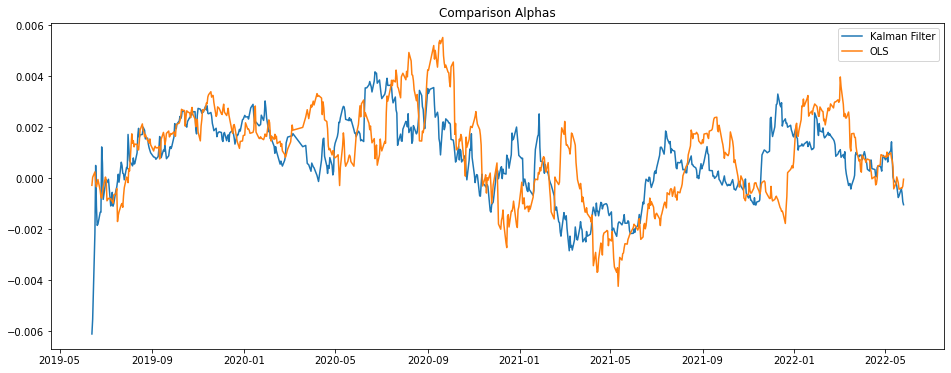

In [40]:


plt.figure(figsize=(16,6))
plt.plot( ret_test.index, alphas, label="Kalman Filter")
plt.plot( ret_test["ols_alpha"], label="OLS" )
plt.legend(); plt.title("Comparison Alphas"); plt.show()



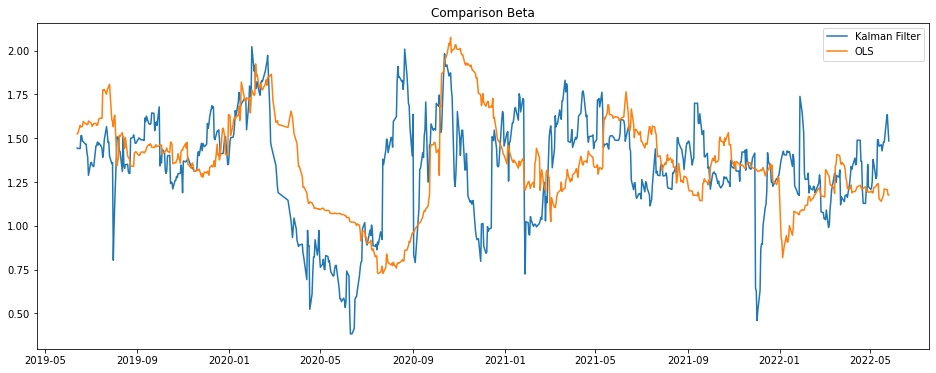

In [41]:


plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter")
plt.plot( ret_test["ols_beta"], label="OLS" )
plt.legend(); plt.title("Comparison Beta"); plt.show()



alpha0, beta0 and var_eps initialized by OLS


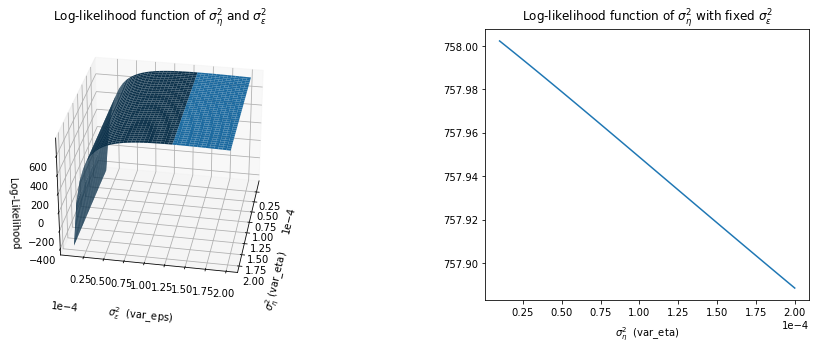

In [42]:


KR = KF.Kalman_regression(ret_train[X], ret_train[Y])



dimens = 40
var_eps_x = np.linspace(1e-5,2e-4,dimens)
var_eta_y = np.linspace(1e-5,2e-4,dimens)
X_grid, Y_grid = np.meshgrid(var_eps_x, var_eta_y)
V_grid = np.ones((dimens,dimens))

for i, i_eps in enumerate(var_eps_x):
    for j, j_eta in enumerate(var_eta_y):
        KR.var_eps = i_eps
        KR.var_eta = j_eta
        KR.run()
        V_grid[j,i] = KR.loglikelihood

KR.set_OLS_params()
V = np.ones(dimens)        
for j, j_eta in enumerate(var_eta_y):
    KR.var_eta = j_eta
    KR.run()
    V[j] = KR.loglikelihood




fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3,2])
ax = fig.add_subplot(gs[0], projection='3d'); ax2 = fig.add_subplot(gs[1])
ax.plot_surface(Y_grid, X_grid, V_grid) #, cmap=cm.ocean
ax.set_title("Log-likelihood function of $\sigma_{\eta}^2$ and $\sigma_{\epsilon}^2$")
ax.set_xlabel("$\sigma_{\eta}^2$ (var_eta)                    ", labelpad=9); 
ax.set_ylabel("$\sigma_{\epsilon}^2$  (var_eps)", labelpad=13); ax.set_zlabel("Log-Likelihood", labelpad=7); 
ax.view_init(30, 10) # this function rotates the 3d plot
ax.ticklabel_format(axis="x", style="sci", scilimits=(-4,2))
ax.ticklabel_format(axis="y", style="sci", scilimits=(-4,2))
ax2.plot(var_eta_y, V)
ax2.set_title("Log-likelihood function of $\sigma_{\eta}^2$ with fixed $\sigma_{\epsilon}^2$")
ax2.set_xlabel("$\sigma_{\eta}^2$  (var_eta)", labelpad=8)
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()



Optimization converged successfully
var_eps = 0.0001324912265039895, var_eta = 0.00013231936747967464
beta_last =  1.477441288532939 P_last =  0.01597680242713081
var_eta_MLE =  0.00013231936747967464 var_eps_MLE =  0.0001324912265039895 var_eps_OLS =  0.0001332473208412866


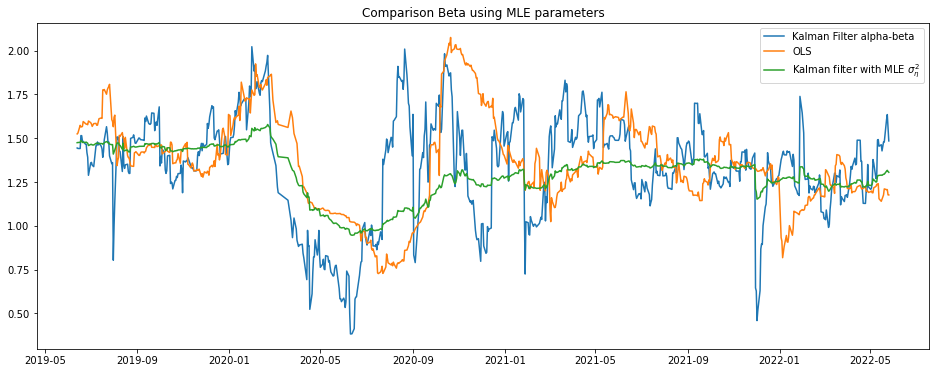

In [43]:


KR.calibrate_MLE()

print("beta_last = ", KR.betas[-1], "P_last = ", KR.Ps[-1])
print("var_eta_MLE = ", KR.var_eta, "var_eps_MLE = ", KR.var_eps, "var_eps_OLS = ", var_eps_ols)

KR.run(ret_test[X], ret_test[Y])

plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter alpha-beta")
plt.plot( ret_test["ols_beta"], label="OLS" )
plt.plot(ret_test.index, KR.betas, label="Kalman filter with MLE $\sigma_{\eta}^2$")
plt.legend(); plt.title("Comparison Beta using MLE parameters"); plt.show()

Optimization converged successfully
var_eta = 1e-15
Optimization converged successfully
var_eta = 1.0


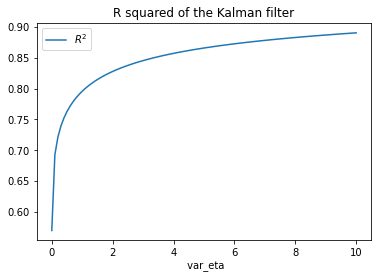

The post-fit R squared is:  0.9812398449525184


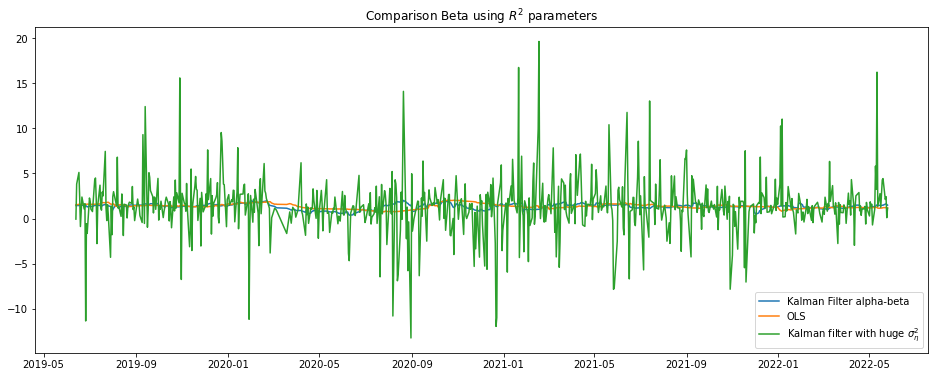

In [44]:


KR.calibrate_R2(mode="pre-fit")



KR.calibrate_R2(mode="post-fit")

xx = np.linspace(0.000001, 10, 100)
RR2 = []
for i in xx:
    KR.run( var_eta=i, var_eps=var_eps_ols)
    RR2.append(KR.R2_post_fit)
plt.plot(xx, RR2, label="$R^2$" )
plt.title("R squared of the Kalman filter"); plt.xlabel(" var_eta"); plt.legend()
plt.show()


var_eta_R2 = 200
KR.run(ret_test[X], ret_test[Y], var_eta=var_eta_R2, var_eps=var_eps_ols)

print("The post-fit R squared is: ", KR.R2_post_fit)



plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter alpha-beta")
plt.plot( ret_test["ols_beta"], label="OLS" )
plt.plot( ret_test.index, KR.betas, label="Kalman filter with huge $\sigma_{\eta}^2$")
plt.legend(); plt.title("Comparison Beta using $R^2$ parameters"); plt.show()



The post-fit R squared is:  0.6153448312842189


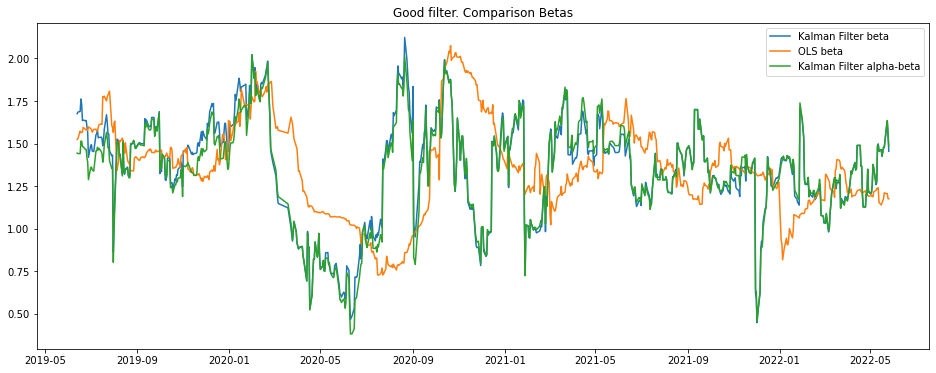

In [45]:


var_eta_good = 0.01
KR.run(var_eta=var_eta_good)       # Run in the training set
KR.beta0 = KR.betas[-1]            # Set initial values
KR.P0 = KR.Ps[-1]
KR.run(ret_test[X], ret_test[Y])   # Run in the test set



print("The post-fit R squared is: ", KR.R2_post_fit)



ret_test = ret_test.assign(Kalman_beta = KR.betas)
ret_test = ret_test.assign(Kalman_err = np.sqrt(KR.Ps) )
ret_test.head()



plt.figure(figsize=(16,6))
plt.plot( ret_test["Kalman_beta"], label="Kalman Filter beta")
plt.plot( ret_test["ols_beta"], label="OLS beta" )
plt.plot( ret_test.index, betas, label="Kalman Filter alpha-beta")
plt.legend(); plt.title("Good filter. Comparison Betas"); plt.show()



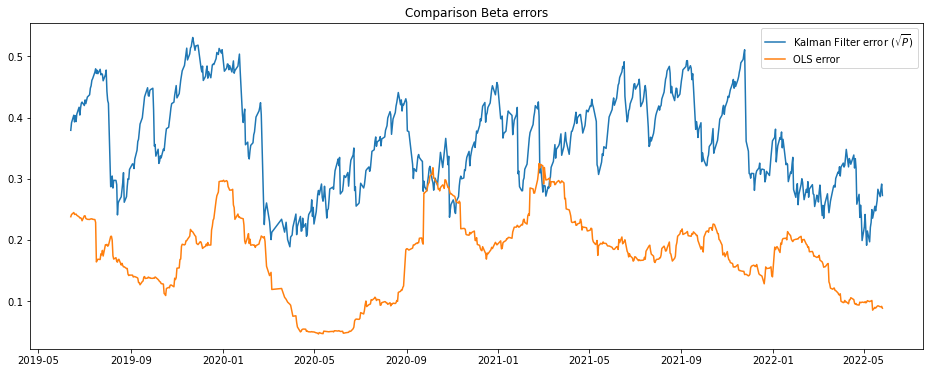

In [46]:
plt.figure(figsize=(16,6))
plt.plot( ret_test["Kalman_err"], label="Kalman Filter error ($\sqrt{P}$)")
plt.plot( ret_test["ols_std_err"], label="OLS error" )
plt.legend(); plt.title("Comparison Beta errors"); plt.show()